In [208]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [209]:
data=pd.read_csv('C:\\Users\\PIYALI\\Ready_data.csv')

In [210]:
data=data.iloc[:,2:]

In [211]:
data.duplicated().sum()

0

In [212]:
y=data['SalePrice']

In [213]:
X=data.drop(columns='SalePrice')

# Feature Selection

In [200]:
from sklearn.inspection import permutation_importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
#rf=RandomFor(n_estimators=100,random_state=42)
GBoost.fit(X_train,y_train)
perm_inp=permutation_importance(rf,X_test,y_test,n_repeats=30,random_state=42)

In [214]:
feats=pd.DataFrame({
    'feature':X.columns,
    'perm_imp':perm_inp.importances_mean
}).sort_values(by='perm_imp',ascending=False).head(80)

In [215]:
feature_list = feats['feature'].tolist()
X = X[feature_list]

In [147]:
from sklearn.metrics import make_scorer

# Define a custom scorer that inverses the log transformation before calculating RMSE
def custom_rmse(y_true, y_pred):
    # Inverse transform the log-transformed target variable
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Create the custom scorer
rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)

def rmse_cv(model, X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring=rmse_scorer, cv=kf))
    return rmse

In [206]:
feature_list

['OverallQual',
 'GrLivArea',
 'Total_sqr_footage',
 'TotalBsmtSF',
 'TotalSF',
 'YrBltAndRemod',
 '1stFlrSF',
 'GarageArea',
 'LotArea',
 'OverallCond',
 'YearRemodAdd',
 'FireplaceQu',
 'YearBuilt',
 'GarageCars',
 'GarageYrBlt',
 'MSZoning_C (all)',
 'CentralAir',
 'MSZoning_RM',
 'GarageFinish',
 'BsmtFinSF1',
 'KitchenQual',
 'GarageType_Detchd',
 'Total_Bathrooms',
 'KitchenAbvGr',
 'ExterCond',
 'PavedDrive',
 'FullBath',
 'Total_porch_sf',
 'TotRmsAbvGrd',
 'BsmtFinType1']

# RIDGE

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
pd.DataFrame(alphas,cv_ridge)

,0
0.132027,0.05
0.131079,0.10
0.129764,0.30
0.129191,1.00
0.130228,3.00
0.131599,5.00
0.134942,10.00
0.137923,15.00
0.145219,30.00
0.152691,50.00


In [13]:
model_ridge = Ridge()

Text(0, 0.5, 'rmse')

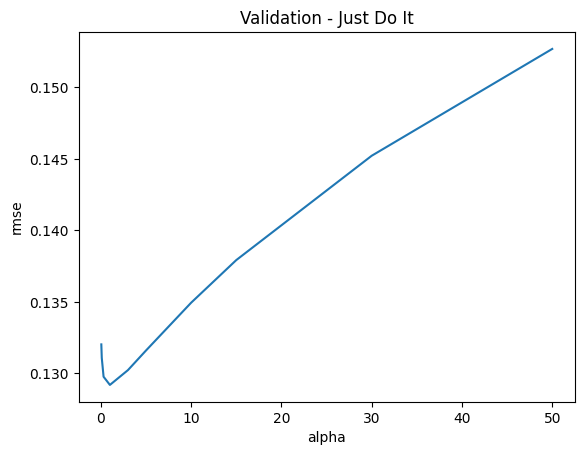

In [14]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
ridge_model = Ridge(alpha=1.0)
rmse1=rmse_cv(model_ridge).mean()
rmse1

0.12919128019779266

# Lasso

In [186]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

In [187]:
selected_alpha = model_lasso.alpha_
print(f'Selected alpha: {selected_alpha}')
rmse2=rmse_cv(model_lasso,X,y).mean()

Selected alpha: 0.0005


In [188]:
print(f'RMSE of Lasso Regression: {rmse2}')

RMSE of Lasso Regression: 161.6586695074197


In [161]:
coef = pd.Series(model_lasso.coef_, index = X.columns)

In [162]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 83 variables and eliminated the other 145 variables


In [23]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

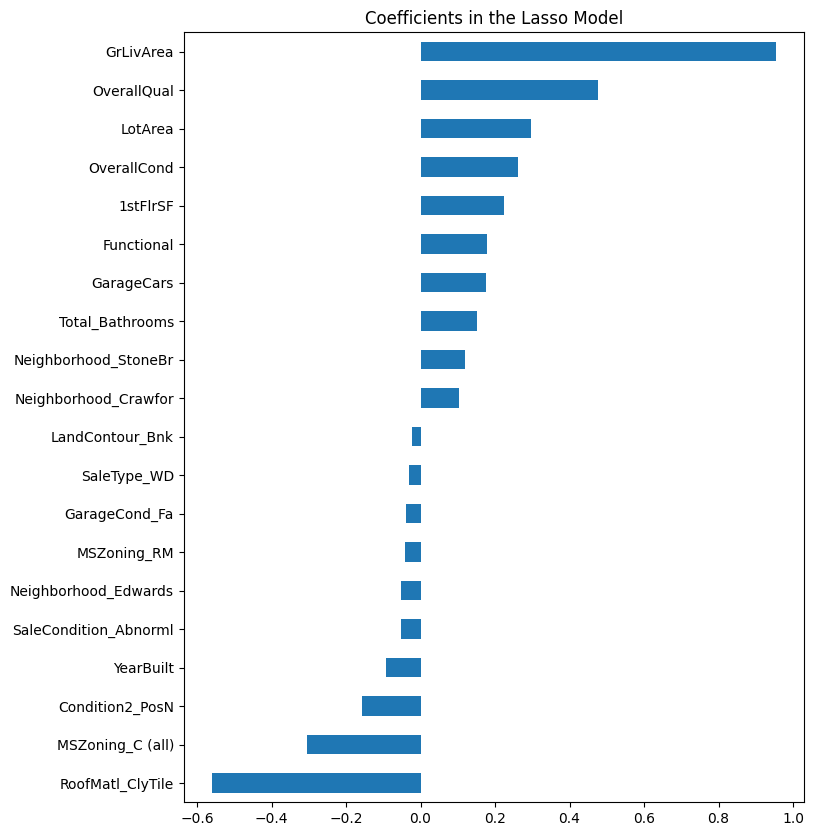

In [24]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<Axes: xlabel='preds', ylabel='residuals'>

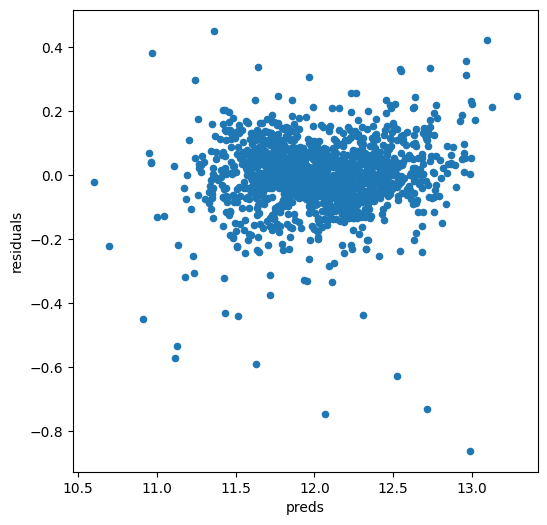

In [27]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# XGBOOST

In [76]:
import xgboost as xgb
xgb=xgb.XGBRegressor()

### BEFORE HYPERPARAMETER OPTIMIZATION

In [71]:
rmse3=rmse_cv(xgb).mean()
rmse3

0.14825051320816493

### AFTER HYPERPARAMETER OPTIMIZATION

In [78]:
'''n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.2]
min_child_weight=[1,2,3,4]

hyperparameter_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster
}'''

In [79]:
'''random_cv=RandomizedSearchCV(estimator=xgb,
                            param_distributions=hyperparameter_grid,
                            cv=5,n_iter=50,
                            scoring='neg_mean_absolute_error',n_jobs=4,
                            verbose=5,
                            return_train_score=True,
                            random_state=42)'''

In [78]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [79]:
score = rmse_cv(model_xgb)
print("\nXgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(sm


Xgb score: 0.1282 (0.0182)



In [88]:
score.mean()

0.12824928252624376

# RANDOM FOREST

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf = RandomForestRegressor()

# Define the hyperparameter grid
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Define and fit the RandomizedSearchCV
random_cv_rf = RandomizedSearchCV(estimator=rf,
                                   param_distributions=hyperparameter_grid,
                                   cv=5, n_iter=50,
                                   scoring='neg_mean_absolute_error', n_jobs=4,
                                   verbose=5,
                                   return_train_score=True,
                                   random_state=42)

random_cv_rf.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [88]:
random_cv_rf.best_params_

{'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 15,
 'bootstrap': True}

In [89]:
selected_model=random_cv_rf.best_estimator_

RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=1100)

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1100,
 min_samples_split=2,
 min_samples_leaf=2,
 max_depth=15,
 bootstrap=True)
rmse_cv(rf)

array([0.14696009, 0.13012018, 0.17822271, 0.14284554, 0.1255308 ])

In [80]:
score1=np.array([0.14696009, 0.13012018, 0.17822271, 0.14284554, 0.1255308 ]).mean()
score1

0.144735864

# AdaBoost

In [91]:
from sklearn.ensemble import AdaBoostRegressor

# Define the model
ada = AdaBoostRegressor()

# Define the hyperparameter grid
n_estimators = [200, 300, 400,1000,1500,2000]
learning_rate = [0.01, 0.1, 0.5, 1.0]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate
}

# Define and fit the RandomizedSearchCV
random_cv_ada = RandomizedSearchCV(estimator=ada,
                                    param_distributions=hyperparameter_grid,
                                    cv=5, n_iter=50,
                                    scoring='neg_mean_absolute_error', n_jobs=4,
                                    verbose=5,
                                    return_train_score=True,
                                    random_state=42)

random_cv_ada.fit(X_train, y_train)


C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [92]:
random_cv_ada.best_params_

{'n_estimators': 200, 'learning_rate': 0.1}

In [101]:
selected_model=random_cv_ada.best_estimator_
selected_model.fit(X_train,y_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=200)

In [102]:
y_pred = selected_model.predict(X_test)
mse5 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test Mean Squared Error: {mse5}')

Test Mean Squared Error: 0.17072872151749505


In [41]:
from sklearn.ensemble import AdaBoostRegressor
ada=AdaBoostRegressor(n_estimators=2000,learning_rate=0.1)
rmse_cv(ada).mean()

0.17162725216950872

In [81]:
score2=0.17162725216950872

# Decision Tree

In [115]:
from sklearn.tree import DecisionTreeRegressor

# Define the model
dt = DecisionTreeRegressor()

# Define the hyperparameter grid
max_depth = [None, 5, 10, 15, 20]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['mse', 'friedman_mse', 'mae']

hyperparameter_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion
}

# Define and fit the RandomizedSearchCV
random_cv_dt = RandomizedSearchCV(estimator=dt,
                                   param_distributions=hyperparameter_grid,
                                   cv=5, n_iter=50,
                                   scoring='neg_mean_absolute_error', n_jobs=4,
                                   verbose=5,
                                   return_train_score=True,
                                   random_state=42)

random_cv_dt.fit(X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
170 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classe

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae'],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [116]:
random_cv_dt.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'friedman_mse'}

In [121]:
selected_model=random_cv_dt.best_estimator_
rmse_cv(selected_model).mean()

0.1904093737659624

In [82]:
score3=0.1904093737659624

# Gradient boosting

In [83]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [84]:
score4 = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score4.mean(), score4.std()))

Gradient Boosting score: 0.1256 (0.0194)



# Elastic Net

In [86]:
ENet = make_pipeline(ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score5=rmse_cv(ENet).mean()
score5

0.12493348802115863

# Averaging Models

In [117]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [216]:
lasso = make_pipeline(Lasso(alpha =0.0005, random_state=1))
averaged_models = AveragingModels(models = (GBoost,lasso,model_xgb))

score6 = rmse_cv(averaged_models,X,y)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score6.mean(), score6.std()))

C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(sm

 Averaged base models score: 148.1975 (8.3757)



In [217]:
score6=score6.mean()
score6

148.19750892316176

In [151]:
(score6**2-164**2)*100/164**2

-20.921021182879596

# Stacking

In [152]:
lasso = make_pipeline(Lasso(alpha =0.0005, random_state=1))
ridge_model = Ridge(alpha=1.0)
estimators=[
    ('xgb',model_xgb),
    ('gboost',GBoost),
    ('lasso',lasso),
    ('enet',ENet)
]

In [153]:
from sklearn.ensemble import StackingRegressor

clf=StackingRegressor(estimators=estimators,
                     final_estimator=ridge_model,
                     cv=5)

In [155]:
rmse_cv(clf,X,y).mean()

C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PIYALI\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(sm

144.51396144505048

In [90]:
score7=0.12086205389556284

In [101]:
results_df = pd.DataFrame({
    'Ridge': [rmse1],
    'Lasso': [rmse2],
    'Elastic Net': [score5],
    'Decision Tree': [score3],
    'Gradient Boosting': [score4.mean()],
    'Ada Boost': [score2],
    'Random Forest': [score1],
    'XGBoost': [score.mean()],
    'Average Models': [score6],
    'Stacking': [score7]
})

print(results_df)

      Ridge    Lasso  Elastic Net  Decision Tree  Gradient Boosting  \
0  0.129191  0.12494     0.124933       0.190409           0.125599   

   Ada Boost  Random Forest   XGBoost  Average Models  Stacking  
0   0.171627       0.144736  0.128249          0.1183  0.120862  
